In [307]:
import pandas as pd
import numpy as np
data = pd.read_csv('COVID data/metadata_2020-12-28_14-16.tsv', sep='\t', header=0)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
data.head()

,strain,virus,gisaid_epi_isl,genbank_accession,date,region,country,division,location,region_exposure,...,Nextstrain_clade,pangolin_lineage,GISAID_clade,originating_lab,submitting_lab,authors,url,title,paper_url,date_submitted
0,Algeria/G0638_2264/2020,ncov,EPI_ISL_418241,?,2020-03-02,Africa,Algeria,Boufarik,NaN,Africa,...,20C,B.1,GH,NIC Viral Respiratory Unit - Institut Pasteur ...,National Reference Center for Viruses of Respi...,Mélanie Albert et al,https://www.gisaid.org,?,?,2020-03-29
1,Algeria/G0640_2265/2020,ncov,EPI_ISL_418242,?,2020-03-08,Africa,Algeria,Blida,NaN,Africa,...,20C,B.1,GH,NIC Viral Respiratory Unit - Institut Pasteur ...,National Reference Center for Viruses of Respi...,Mélanie Albert et al,https://www.gisaid.org,?,?,2020-03-29
2,Algeria/G0860_2262/2020,ncov,EPI_ISL_420037,?,2020-03-02,Africa,Algeria,Boufarik,NaN,Africa,...,20C,B.1,GH,NIC Viral Respiratory Unit - Institut Pasteur ...,National Reference Center for Viruses of Respi...,Mélanie Albert et al,https://www.gisaid.org,?,?,2020-04-04
3,Andorra/202552/2020,ncov,EPI_ISL_539496,?,2020-03-13,Europe,Andorra,Andorra,NaN,Europe,...,20A,B.1.5,O,Hospital Nostra Senyora de Meritxell,Instituto de Salud Carlos III,Iglesias-Caballero et al,https://www.gisaid.org,?,?,2020-09-18
4,Anhui/SZ005/2020,ncov,EPI_ISL_413485,?,2020-01-24,Asia,China,Anhui,Suzhou,Asia,...,19B,A,S,"Department of microbiology laboratory,Anhui Pr...","Department of microbiology laboratory,Anhui Pr...",Weiwei Li et al,https://www.gisaid.org,?,?,2020-03-05


## Selecting featured countries

Select countries with less then 10k sequences and draw hist of number of sequences (to select bounds for featured)

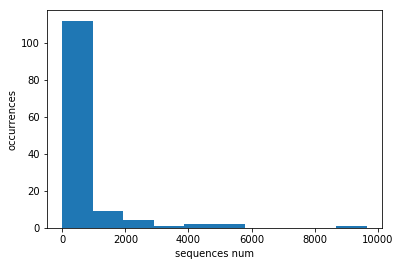

In [431]:
from collections import Counter
import matplotlib.pyplot as plt
counted = Counter(data['country'])
cnt = list(filter(lambda x: x < 10000, counted.values()))
plt.hist(list(cnt))
plt.xlabel('sequences num')
plt.ylabel('occurrences')
plt.show()

In [11]:
list(filter(lambda x: x[1] > 2000, dict(counted).items()))

[('Australia', 16540),
 ('Belgium', 2731),
 ('Netherlands', 4587),
 ('Canada', 3604),
 ('Denmark', 16790),
 ('United Kingdom', 137179),
 ('France', 2726),
 ('India', 4236),
 ('Japan', 9649),
 ('Portugal', 2203),
 ('USA', 52254),
 ('South Africa', 2801),
 ('Spain', 5612),
 ('Switzerland', 4953)]

Manually select featured: small countries with many secuences processed

In [12]:
top_countries = ['Belgium', 'Netherlands', 'Denmark', 'France', 'Japan', 'Portugal', 'South Africa', 'Spain', 'Switzerland']

## Prepare country-separated data

In [13]:
from collections import defaultdict
top_countries_dict = data.loc[data['country'].isin(top_countries)]['country'].to_dict()
grouped_ids = defaultdict(set)
for k, v in top_countries_dict.items():
    grouped_ids[v].add(k)

In [72]:
def create_country_file(country):
    with open('COVID data/msa_1229/msa_1229.fasta') as f:
        meta = f.readline()
        v = 0

        while meta:
            sequence = f.readline()
            if country in meta:
                with open(f"COVID data/msa_1229/countries/{country}.fasta", "a+") as cf:
                    cf.writelines([meta, sequence])
            v += 1

            meta = f.readline()

    print(v)

In [73]:
create_country_file("Belgium")

276018


In [31]:
metas = 0
v = 0
ids = set(data.loc[data['country'] == 'Belgium']['strain'].tolist())

bel_ids = set()

with open('COVID data/msa_1229/msa_1229.fasta') as f:
    meta = f.readline()
    while meta:
        sequence = f.readline()
        id_ = meta.split("|")[0][9:]
        if id_ in ids:
            bel_ids.add(id_)
        
        meta = f.readline()

In [17]:
from tqdm import tqdm

belgium = []
metas = []
common_len = 0
with open("COVID data/Belgium.fasta", "r") as cf:
    meta = cf.readline()
    while meta:
        seq = cf.readline()
        metas.append(meta)
        belgium.append(seq)  
        meta = cf.readline()
    
print(len(belgium))

final_sequences = []
spaces = []
for seq in tqdm(list(zip(*belgium))):
    spaces.append(seq.count('-') * 1.0 / len(seq))
    if seq.count('-') * 1.0 / len(seq) > 0.1:
        continue
    final_sequences.append(seq)
print((final_sequences))

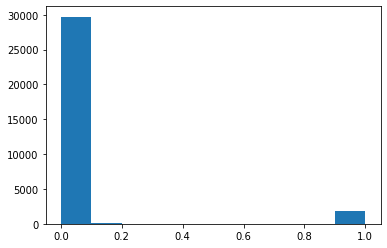

In [77]:
plt.hist(spaces)
plt.show()

## Sequences analysis

Draw hist for some subtrees and trendline to understend dynamics of key mutations distrubution

In [499]:
from collections import defaultdict
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

def get_date_from_meta(meta):
    return meta.split("|")[2]

def get_id_from_meta(meta):
    return meta.split("/")[2]

def get_timestamp(date: str):
    return mdates.epoch2num(datetime.strptime(date, '%Y-%m-%d').timestamp())

def show_hist(n, bins, polynom=None, width=1):
    fig, ax = plt.subplots(1,1)
    ax.bar(bins[:-1], n, width=width)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))
    if polynom is not None:
        ax.plot(bins, polynom(bins), "r--")
    plt.xlabel('months')
    plt.ylabel('occurrences')
    plt.show()

def prepare_hist(leaves, bins_n):
    bounds = (get_timestamp('2019-12-24'), get_timestamp('2021-01-10'))
    dates = [get_timestamp(get_date_from_meta(leaf)) for leaf in leaves]
    mpl_data = dates
    return np.histogram(mpl_data, bins=bins_n)
    
def draw_date_histogramm_by_subtree(leaves, bins_n=50, force_draw=False, min_k=0.02):
    n, bins = prepare_hist(leaves, bins_n)
    z = np.polyfit(bins[:-1], n, 1)
    if z[0] > min_k or force_draw:
        print(f'Subtree size: {len(leaves)}')
        print(f'Trendline coefficient: {z[0]}')
        p = np.poly1d(z)
        show_hist(n, bins, p)

In [125]:
import io
from newick import load
with io.open('COVID data/tree_raw.nwk', encoding='utf8') as fp:
    tree2 = load(fp)[0]

Subtree size: 2587
Trendline coefficient: 0.028486642181781287


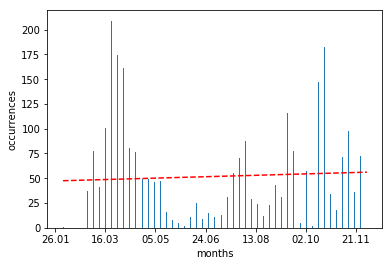

In [502]:
leafs = tree2.get_leaf_names()
draw_date_histogramm_by_subtree(leafs, force_draw=True)

Subtree size: 75
Trendline coefficient: 0.024743781810229414


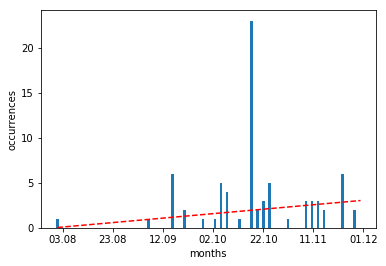

Subtree size: 41
Trendline coefficient: 0.03171138585307399


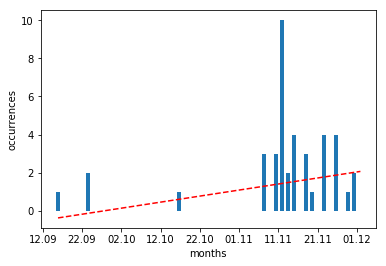

Subtree size: 89
Trendline coefficient: 0.027747807984107243


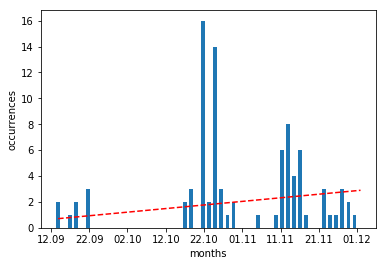

In [504]:
def _dig(node, stop_fn):
    if not stop_fn(node):
        res = []
        for descendant in node.descendants:
            if not descendant.is_leaf:
                res += _dig(descendant, stop_fn)
        return res
    else:
        return [node]

def analyze_subtree(subroot):
    for i in _dig(subroot, lambda node: len(node.get_leaves()) < 100):
        leaves = i.get_leaf_names()
        if len(leaves) < 30:
            continue
        draw_date_histogramm_by_subtree(leaves)
        
analyze_subtree(tree2)